In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from konlpy.tag import Kkma
from konlpy.utils import pprint
from konlpy.tag import Okt

In [3]:
import re

In [20]:
# 그래프 한글 깨짐
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc
import platform

plt.rc('font', family='NanumBarunGothic')


matplotlib.rcParams['axes.unicode_minus'] = False
#그래프에서 마이너스 기호가 표시되도록 하는 설정입니다.

#warning 메시지 무시
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
df = pd.read_csv("./mail.csv")
df.head(5)

,보낸이,메일주소,제목,내용,스팸여부
0,네이버 시리즈,series_noreply@webtoonscorp.com,[네이버 시리즈] '히든 특성 13개 ...'의 구매 내역을 안내해 드립니다.,NaN,1
1,""" 현금이벤트 """,nbadmin2@imga1.com,(광고) 않바꾸면 손해! 인터넷 변경하고 현금 47만원 받아가세요~,"<table width=""100%"" border=""0"" cellspacing=""0""...",0
2,네이버 시리즈,series_noreply@webtoonscorp.com,[네이버 시리즈] '아카데미 편의점으로...'의 구매 내역을 안내해 드립니다.,NaN,1
3,네이버 시리즈,series_noreply@webtoonscorp.com,[네이버 시리즈] '나 혼자 탑에서 농...'의 구매 내역을 안내해 드립니다.,NaN,1
4,네이버 시리즈,series_noreply@webtoonscorp.com,[네이버 시리즈] '멸망 예정인 아카데...'의 구매 내역을 안내해 드립니다.,NaN,1


In [9]:
df = df.dropna(subset=["제목"])

In [10]:
notnull_df = df.loc[:,["스팸여부","제목"]]

In [11]:
notnull_df

,스팸여부,제목
0,1,[네이버 시리즈] '히든 특성 13개 ...'의 구매 내역을 안내해 드립니다.
1,0,(광고) 않바꾸면 손해! 인터넷 변경하고 현금 47만원 받아가세요~
2,1,[네이버 시리즈] '아카데미 편의점으로...'의 구매 내역을 안내해 드립니다.
3,1,[네이버 시리즈] '나 혼자 탑에서 농...'의 구매 내역을 안내해 드립니다.
4,1,[네이버 시리즈] '멸망 예정인 아카데...'의 구매 내역을 안내해 드립니다.
...,...,...
178,0,한국 Twitch에 대한 주요 공지사항
179,1,YouTube Premium 가격 업데이트
180,0,"안녕, 마테오 👋"
181,1,보안 알림


In [12]:
notnull_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 182
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   스팸여부    182 non-null    int64 
 1   제목      182 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.3+ KB


In [15]:
notnull_df.shape

(182, 2)

In [16]:
print('제목의 유니크한 값 :',notnull_df['제목'].nunique())
# 182개중 유니크한 값이 133개라는 것은 중복값이 존재한다는 의미

제목의 유니크한 값 : 133


In [18]:
# 중복 값들을 제거
notnull_df.drop_duplicates(subset=['제목'], inplace=True)
print('총 샘플의 수 :',len(notnull_df))

총 샘플의 수 : 133


정상 메일과 스팸 메일의 개수
   스팸여부  count
0     0     90
1     1     43


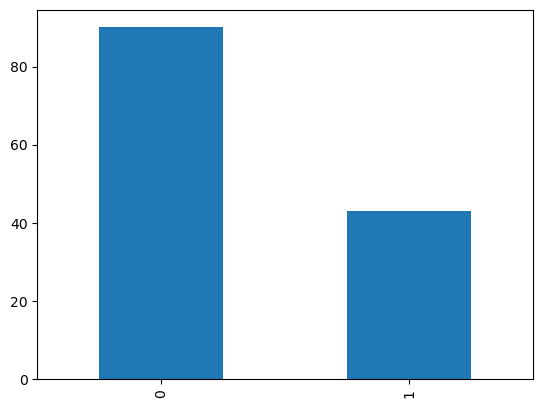

In [28]:
notnull_df['스팸여부'].value_counts().plot(kind='bar')
print('정상 메일과 스팸 메일의 개수')
print(notnull_df.groupby('스팸여부').size().reset_index(name='count'))
# 스팸 90건, 일반 메일 43건
# 데이터의 갯수도 적지만, 대부분이 스팸 메일이다.

In [31]:
print(f'스팸 메일의 비율 = {round(notnull_df["스팸여부"].value_counts()[0]/len(notnull_df) * 100,2)}%')
print(f'정상 메일의 비율 = {round(notnull_df["스팸여부"].value_counts()[1]/len(notnull_df) * 100,2)}%')

스팸 메일의 비율 = 67.67%
정상 메일의 비율 = 32.33%


In [35]:
X_data = notnull_df['제목']
y_data = notnull_df['스팸여부']
# 학습대상과 정답을 분리

In [6]:
from tqdm import tqdm
tqdm.pandas()

In [7]:
okt = Okt()

In [8]:
def okt_clean(text):
    # 입력이 문자열인지 확인하고, 아니라면 적절히 처리
    if isinstance(text, str):
        clean_text = []
        for word in okt.pos(text, norm=True, stem=True):
            if word[1] not in ['Josa', 'Eomi', 'Punctuation']:
                clean_text.append(word[0])
        return " ".join(clean_text)
    else:
        # 입력이 문자열이 아닌 경우 문자열로 변환
        return str(text)

notnull_df["제목"] = notnull_df["제목"].progress_apply(okt_clean)

100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:03<00:00, 46.52it/s]


In [9]:
notnull_df["제목"] = notnull_df["제목"].progress_map(okt_clean)

100%|███████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 548.70it/s]


In [10]:
notnull_df.head(1)

,보낸이,메일주소,제목,내용,스팸여부
0,네이버 시리즈,series_noreply@webtoonscorp.com,네이버 시리즈 히든 특성 13 개 의 구매 내 역 안내 하다 드리다,NaN,1


In [11]:
# 불용어 제거함수 만들기
def remove_stopwords(text):
    tokens = text.split(' ')
    # 직점 작성
    stops = [ '합니다', '하는', '할', '하고', '한다', 
             '그리고', '입니다', '그', '등', '이런', '및','제', '더',
            '받다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [12]:
notnull_df["제목"] = notnull_df["제목"].map(remove_stopwords)

In [13]:
notnull_df["제목"]

0                  네이버 시리즈 히든 특성 13 개 의 구매 내 역 안내 하다 드리다
1                            광고 않다 바꾸다 손해 인터넷 변경 현금 47만원
2                    네이버 시리즈 아카데미 편의점 의 구매 내 역 안내 하다 드리다
3                    네이버 시리즈 나 혼자 탑 농 의 구매 내 역 안내 하다 드리다
4                  네이버 시리즈 멸망 예정 아 크다 의 구매 내 역 안내 하다 드리다
                             ...                        
178                                한국 Twitch 대한 주요 공지 사항
179                              YouTube Premium 가격 업데이트
180                                            안녕 마 테오 👋
181                                                보안 알림
182    와디 즈 10만원 대다 소 가죽 수제 화 초 경량 키 높이 5.5 cm 직장인 더비...
Name: 제목, Length: 183, dtype: object

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
print(X_train_encoded[:5])